In [1]:
import os, random
import cv2
import math
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision.models import efficientnet
from torchvision.transforms import transforms
import torchaudio

import timm

import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from glob import glob
from IPython.display import display, Audio

import cupy as cp
from cupyx.scipy import signal as cupy_signal
import yaml

from metric import score

import wandb

import plotly.graph_objects as go
import plotly.express as px

c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lhk. Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
default_config = {
    "VERSION": "v0.3",
    "DATA_PATH": "inputs",
    "LOAD_SPEC_DATA": True,
    "SEED": 24,
    "SAMPLE_RATE": 32000,
    "N_FFT": 1095,
    "WIN_SIZE": 412,
    "WIN_LAP": 100,
    "MIN_FREQ": 40,
    "MAX_FREQ": 15000,
    "EPOCHS": 10,
    "BACHSIZE": 16
}

try:
    with open('config.yaml', 'r') as f:
        default_config = yaml.load(f, Loader=yaml.SafeLoader)
except:
    pass

default_config

{'VERSION': 'v1.5',
 'DESCRIPTION': '3 Level Hierarchical with weighted loss',
 'DATA_PATH': 'inputs',
 'LOAD_SPEC_DATA': 'data/spec_center_5sec_256_256.npy',
 'SEED': 24,
 'SAMPLE_RATE': 32000,
 'N_FFT': 1024,
 'WIN_SIZE': 412,
 'WIN_LAP': 100,
 'MIN_FREQ': 40,
 'MAX_FREQ': 15000,
 'N_MEL': 128,
 'HOP_LENGTH': 320,
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 16,
 'LABEL_SMOOTHING': 0.0}

In [6]:
# Reproducibility
torch.manual_seed(default_config["SEED"])
torch.cuda.manual_seed(default_config["SEED"])
random.seed(default_config["SEED"])
np.random.seed(default_config["SEED"])

In [10]:
if default_config["LOAD_SPEC_DATA"]:
        all_bird_data = np.load(default_config["LOAD_SPEC_DATA"], allow_pickle=True).item()
        # all_bird_data1 = np.load("data/spec_center_5sec_256_256_add1.npy", allow_pickle=True).item()
        # all_bird_data2 = np.load("data/spec_center_5sec_256_256_add2.npy", allow_pickle=True).item()

In [11]:
meta_data = pd.DataFrame(all_bird_data.items(), columns=["filename","audioarray"])
# meta_data1 = pd.DataFrame(all_bird_data1.items(), columns=["filename","audioarray"])
# meta_data2 = pd.DataFrame(all_bird_data2.items(), columns=["filename","audioarray"])

meta_data[meta_data.isna().any(axis=1)]

,filename,audioarray


In [12]:
def drop_startidx(x):
    return x.split("_")[0]

def get_primary_label(x):
    return x.split("/")[0]

meta_data['primary_label'] = meta_data["filename"].apply(get_primary_label)
# meta_data1['primary_label'] = meta_data1["filename"].apply(get_primary_label)
# meta_data2['primary_label'] = meta_data2["filename"].apply(get_primary_label)

meta_data = meta_data[["audioarray", "primary_label"]]
# meta_data1 = meta_data1[["audioarray", "primary_label"]]
# meta_data2 = meta_data2[["audioarray", "primary_label"]]


# meta_data = pd.concat([meta_data,meta_data1, meta_data2]).reset_index(drop=True)
meta_data

,audioarray,primary_label
0,"[[0.5531187, 0.4614128, 0.46884865, 0.4733932,...",asbfly
1,"[[0.89844084, 0.8390864, 0.83963215, 0.8028418...",asbfly
2,"[[0.67720044, 0.6433395, 0.67541385, 0.6594999...",asbfly
3,"[[0.792005, 0.8313101, 0.7425628, 0.7411859, 0...",asbfly
4,"[[0.8458731, 0.7915678, 0.7997656, 0.8355528, ...",asbfly
...,...,...
24454,"[[0.7833048, 0.7419587, 0.76757, 0.73821497, 0...",zitcis1
24455,"[[0.8710316, 0.8813897, 0.77745366, 0.82180923...",zitcis1
24456,"[[0.91621995, 0.81297827, 0.85424167, 0.812879...",zitcis1
24457,"[[0.74634314, 0.7503123, 0.7584076, 0.74119496...",zitcis1


In [13]:
hier_mapping = pd.read_csv("inputs/hier_mapping.csv")
def get_order(row):
    return hier_mapping[hier_mapping["SPECIES"]==row["primary_label"]].ORDER.to_numpy()[0]
def get_family(row):
    return hier_mapping[hier_mapping["SPECIES"]==row["primary_label"]].FAMILY.to_numpy()[0]

meta_data['order'] = meta_data.apply(get_order, axis=1)
meta_data['family'] = meta_data.apply(get_family, axis=1)
meta_data

,audioarray,primary_label,order,family
0,"[[0.5531187, 0.4614128, 0.46884865, 0.4733932,...",asbfly,Passeriformes,Muscicapidae (Old World Flycatchers)
1,"[[0.89844084, 0.8390864, 0.83963215, 0.8028418...",asbfly,Passeriformes,Muscicapidae (Old World Flycatchers)
2,"[[0.67720044, 0.6433395, 0.67541385, 0.6594999...",asbfly,Passeriformes,Muscicapidae (Old World Flycatchers)
3,"[[0.792005, 0.8313101, 0.7425628, 0.7411859, 0...",asbfly,Passeriformes,Muscicapidae (Old World Flycatchers)
4,"[[0.8458731, 0.7915678, 0.7997656, 0.8355528, ...",asbfly,Passeriformes,Muscicapidae (Old World Flycatchers)
...,...,...,...,...
24454,"[[0.7833048, 0.7419587, 0.76757, 0.73821497, 0...",zitcis1,Passeriformes,Cisticolidae (Cisticolas and Allies)
24455,"[[0.8710316, 0.8813897, 0.77745366, 0.82180923...",zitcis1,Passeriformes,Cisticolidae (Cisticolas and Allies)
24456,"[[0.91621995, 0.81297827, 0.85424167, 0.812879...",zitcis1,Passeriformes,Cisticolidae (Cisticolas and Allies)
24457,"[[0.74634314, 0.7503123, 0.7584076, 0.74119496...",zitcis1,Passeriformes,Cisticolidae (Cisticolas and Allies)


In [14]:
del all_bird_data

In [15]:
species_list = sorted(meta_data["primary_label"].unique())
id_list = list(range(len(species_list)))
species2id = dict(zip(species_list, id_list))
id2species = dict(zip(id_list, species_list))

order_list = sorted(meta_data["order"].unique())
id_list = list(range(len(order_list)))
order2id = dict(zip(order_list, id_list))
id2order = dict(zip(id_list, order_list))

family_list = sorted(meta_data["family"].unique())
id_list = list(range(len(family_list)))
family2id = dict(zip(family_list, id_list))
id2family = dict(zip(id_list, family_list))

# sample_count = meta_data["primary_label"].value_counts()
# minority_class = sample_count[sample_count<50].index.values
# minority_class = [species2id[lbl] for lbl in minority_class]

<Axes: title={'center': 'Amount of sample in each class'}, xlabel='primary_label'>

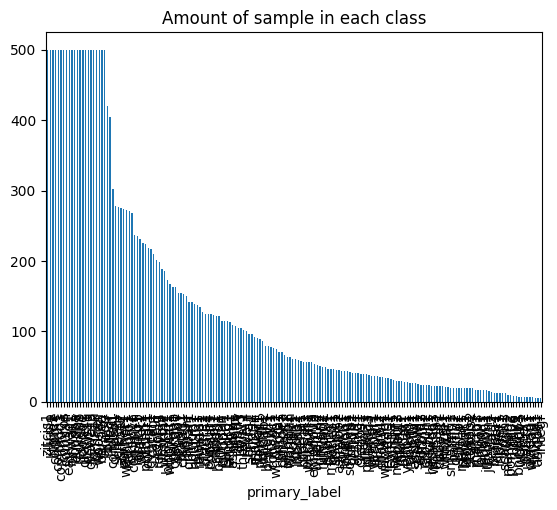

In [16]:
meta_data["primary_label"].value_counts().plot(kind='bar', title='Amount of sample in each class')

In [17]:
class BirdCLEF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df_data):
        super(BirdCLEF_Dataset).__init__()
        self.df_data = df_data
        # self.transform = transforms

    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        X = np.array([self.df_data.iloc[index].audioarray])
        y_order = order2id[self.df_data.iloc[index].order]
        y_family = family2id[self.df_data.iloc[index].family]
        y_species = species2id[self.df_data.iloc[index].primary_label]


        # if (y in minority_class):
        #     x = self.transform(x)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_order, dtype=torch.long), torch.tensor(y_family, dtype=torch.long), torch.tensor(y_species, dtype=torch.long)

In [18]:
class BirdCLEF_Model_EfficientnetB0(nn.Module):
    def __init__(self, num_class):
        super(BirdCLEF_Model_EfficientnetB0, self).__init__()
        self.backbone = timm.create_model('tf_efficientnet_b0.in1k', pretrained=True, in_chans=1,  num_classes=num_class)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
class BirdCLEF_Model_EfficientnetB0_Hier(nn.Module):
    def __init__(self):
        super(BirdCLEF_Model_EfficientnetB0_Hier, self).__init__()
        self.feature_attraction = timm.create_model('tf_efficientnet_b0.in1k', pretrained=True, in_chans=1,  num_classes=0)
        self.order_head = nn.Linear(1280, 19)
        self.family_head = nn.Linear(1299, 60)
        self.species_head = nn.Linear(1359, 182)

        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x_feature = self.feature_attraction(x)

        x_order = self.order_head(x_feature)
        x_order = self.sigmoid(x_order)
        x_feature = torch.cat((x_order,x_feature), dim=1)

        x_family = self.family_head(x_feature)
        x_family = self.sigmoid(x_family)
        x_feature = torch.cat((x_family,x_feature),dim=1)
    
        x_species = self.species_head(x_feature)
        return x_order, x_family, x_species


(dot.exe:5172): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


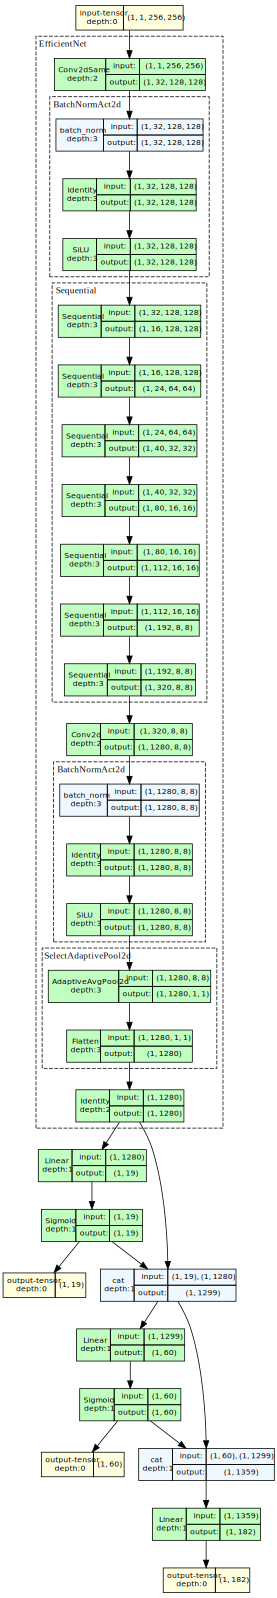

In [20]:
import torchview
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'
model_graph = torchview.draw_graph(BirdCLEF_Model_EfficientnetB0_Hier(), input_size=(1,1,256,256), expand_nested=True)
model_graph.visual_graph

In [21]:
ssk = StratifiedKFold(n_splits=default_config["FOLD"], shuffle=True, random_state=default_config["SEED"])
meta_data['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(ssk.split(np.zeros(len(meta_data)), meta_data["primary_label"].to_numpy())):
    meta_data.loc[val_idx, 'fold'] = fold

In [22]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

for f in range(default_config["FOLD"]):
    run = wandb.init(project="BirdCLEF2024_LeviKaay", name=f"BaseModel_EfficientB0_Fold{f}_{default_config['VERSION']}", entity="Kaay", config=default_config)
    
    # main loop of f-fold
    print('================================================================')
    print(f"==== Running training for fold {f} ====")
    
    train_df = meta_data[meta_data['fold'] != f].copy().reset_index(drop=True)
    valid_df = meta_data[meta_data['fold'] == f].copy().reset_index(drop=True)
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    train_dataset = BirdCLEF_Dataset(train_df)
    valid_dataset = BirdCLEF_Dataset(valid_df)

    #-------------Over sampling---------------
    class_weights = train_df.groupby(["primary_label"]).size().to_dict()
    class_weights = dict((species2id[label], (num/len(train_df))**(-0.5)) for (label, num) in class_weights.items())

    sample_weights = [0] * len(train_dataset)
    for idx, (features, order, family, species) in enumerate(train_dataset):
        sample_weights[idx] = class_weights[species.item()]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], sampler=sampler)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

    model = BirdCLEF_Model_EfficientnetB0_Hier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=default_config["LABEL_SMOOTHING"])

    # criterion = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')

    # Training loop
    for epoch in range(default_config["EPOCHS"]):
        for idx, batch in enumerate(train_dataloader):
            inputs, order_targets, family_targets, species_targets = batch

            inputs = inputs.to(device)
            order_targets = order_targets.to(device)
            family_targets = family_targets.to(device)
            species_targets = species_targets.to(device)

            # targets = torch.nn.functional.one_hot(targets, len(label_list)).to(device).float()
            optimizer.zero_grad()
            # Forward pass
            order_outputs, family_outputs, species_outputs = model(inputs)
            
            # Compute loss
            order_loss = criterion(order_outputs, order_targets)
            family_loss = criterion(family_outputs, family_targets)
            species_loss = criterion(species_outputs, species_targets)

            total_loss = 0.5*order_loss +  0.3*family_loss + 0.2*species_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            print(f'Step {idx}/{len(train_dataloader)}, Loss: {total_loss.item():.4f}\r', end='', flush=True)
            wandb.log({"Learning Rate": scheduler.get_last_lr()[0],
                       "Training Loss": total_loss,
                       "Order Training Loss": order_loss,
                       "Family Training Loss": family_loss,
                       "Species Training Loss": species_loss})
        model.eval()
        valid_step = []
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                inputs, order_targets, family_targets, species_targets = batch
                inputs = inputs.to(device)
                order_targets = order_targets.to(device)
                family_targets = family_targets.to(device)
                species_targets = species_targets.to(device)

                order_outputs, family_outputs, species_outputs = model(inputs)

                order_loss = criterion(order_outputs, order_targets)
                family_loss = criterion(family_outputs, family_targets)
                species_loss = criterion(species_outputs, species_targets)

                val_loss = 0.5*order_loss +  0.3*family_loss + 0.2*species_loss

                valid_step.append({"logits": species_outputs, "targets": species_targets})

                wandb.log({"Valid Loss": val_loss, 
                           "Order Valid Loss": order_loss,
                            "Family Valid Loss": family_loss,
                            "Species Valid Loss": species_loss})
            
            output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
            target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

            val_loss = criterion(output_val, target_val)
            target_val = torch.nn.functional.one_hot(target_val, len(species_list))
            
            gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=species_list)
            pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=species_list)
            
            gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
            pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]

            val_roc_auc = score(gt_df, pred_df, row_id_column_name='id')
        
        print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {total_loss.item():.4f}, valid_loss: {val_loss:.4f} valid_roc_auc: {val_roc_auc:.4f}, lr: {scheduler.get_last_lr()}")
        wandb.log({"Valid Loss": val_loss ,"Valid ROC_AUC": val_roc_auc})
    run.finish()
    torch.save(model.state_dict(), f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{f}.pt")


wandb: Currently logged in as: lhk (Kaay). Use `wandb login --relogin` to force relogin


==== Running training for fold 0 ====
Train Samples: 19567
Valid Samples: 4892
Epoch 1/10, train_loss: 3.3081, valid_loss: 4.2726 valid_roc_auc: 0.7736, lr: [4.762017696620708e-05]
Epoch 2/10, train_loss: 2.7160, valid_loss: 2.6065 valid_roc_auc: 0.9183, lr: [0.00012924034395422874]
Epoch 3/10, train_loss: 2.3429, valid_loss: 2.4157 valid_roc_auc: 0.9310, lr: [0.00016999999427681298]
Epoch 4/10, train_loss: 2.3421, valid_loss: 2.3542 valid_roc_auc: 0.9236, lr: [0.0001615688486050954]
Epoch 5/10, train_loss: 2.2208, valid_loss: 2.5659 valid_roc_auc: 0.9259, lr: [0.00013797237075300592]
Epoch 6/10, train_loss: 2.1905, valid_loss: 2.5204 valid_roc_auc: 0.9228, lr: [0.00010388413255096036]
Epoch 7/10, train_loss: 2.1253, valid_loss: 2.7238 valid_roc_auc: 0.9229, lr: [6.605572763967985e-05]
Epoch 8/10, train_loss: 1.9941, valid_loss: 2.9755 valid_roc_auc: 0.9170, lr: [3.197953554678399e-05]
Epoch 9/10, train_loss: 2.0788, valid_loss: 3.1887 valid_roc_auc: 0.9184, lr: [8.404764033341025e-06]

Family Training Loss,███▆▇▄▄▄▃▄▃▂▃▃▂▃▃▂▃▂▂▁▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁
Family Valid Loss,█▇▇▇▃▄▂▄▄▃▄▃▃▃▆▁▃▄▂▃▁▃▄▅▃▄▅▅▂▃▃▃▂▁▇▅▃▃▃▃
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Order Training Loss,██▇▅▆▃▃▃▂▃▂▂▂▂▃▁▂▂▂▁▁▂▁▁▃▂▂▂▃▁▁▁▂▁▃▁▂▂▁▁
Order Valid Loss,▇▆▅█▄▃▃▅▄▄▃▅▃▃▆▅▄▃▃▂▃▂▃▃▅▂▅▄▃▃▄▃▃▃▁▄▆▃▂▆
Species Training Loss,███▇▇▅▅▃▄▃▃▂▃▃▃▂▂▂▃▂▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Species Valid Loss,▅▄▄▄▂▂▂▄▂▂▃▂▃▂▃▃▃▃▂▅▁▃▄▄▅▃▄▂▂▃▂▄▃▁▅█▄▃▁▃
Training Loss,███▇▇▄▄▃▄▃▃▂▃▃▃▂▂▂▃▂▂▁▂▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁
Valid Loss,▇▆▆▇▃▄▄▄▄▂▃▄▅▃▂▄▁▃▄▃▃▂▁▄▂▇▄▃▆▅▅▄▇▅▄▇█▅▃▄
Valid ROC_AUC,▁▇█████▇▇▇
Family Training Loss,3.12983


==== Running training for fold 1 ====
Train Samples: 19567
Valid Samples: 4892
Epoch 1/10, train_loss: 3.4002, valid_loss: 4.2327 valid_roc_auc: 0.7959, lr: [4.762017696620708e-05]
Epoch 2/10, train_loss: 2.6996, valid_loss: 2.5419 valid_roc_auc: 0.9167, lr: [0.00012924034395422874]
Epoch 3/10, train_loss: 2.2204, valid_loss: 2.6911 valid_roc_auc: 0.9262, lr: [0.00016999999427681298]
Epoch 4/10, train_loss: 2.3307, valid_loss: 2.5968 valid_roc_auc: 0.9290, lr: [0.0001615688486050954]
Epoch 5/10, train_loss: 2.1012, valid_loss: 2.4672 valid_roc_auc: 0.9313, lr: [0.00013797237075300592]
Epoch 6/10, train_loss: 2.0850, valid_loss: 2.5520 valid_roc_auc: 0.9303, lr: [0.00010388413255096036]
Epoch 7/10, train_loss: 2.1209, valid_loss: 2.8115 valid_roc_auc: 0.9298, lr: [6.605572763967985e-05]
Epoch 8/10, train_loss: 2.0172, valid_loss: 3.0490 valid_roc_auc: 0.9271, lr: [3.197953554678399e-05]
Epoch 9/10, train_loss: 1.9598, valid_loss: 3.2898 valid_roc_auc: 0.9281, lr: [8.404764033341025e-06]

Family Training Loss,██▇▇▆▅▅▃▃▃▄▃▃▃▂▂▂▂▂▁▁▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁
Family Valid Loss,▇█▅█▃▅▂▄▅▅▂▂▂▄▂▂▄▄▁▄▃▃▂▁▁▃▂▂▃▄▅▁▃▂▄▄▅▃▃▃
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Order Training Loss,█▇▇▅▄▄▃▃▃▄▂▃▂▂▂▂▁▂▃▁▃▂▂▃▂▃▂▂▂▁▁▁▁▂▂▁▂▁▁▁
Order Valid Loss,▇▆▇█▄▆▅▄▇▆▂▂▂▅▂▆▄▄▅▄▂▂▃▃▃▃▂▅▅▄▅▁▅▄▆▅▄▄▄▄
Species Training Loss,████▇▆▅▄▃▄▄▄▃▂▃▂▃▁▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Species Valid Loss,▆▇▆▇▄▆▃▄▃▅▁▁▂▆▂▃▄▅▁▇▃▆▂▁▆▅▅▃▄▂▇▂█▄▅▆▃▁▅▄
Training Loss,███▇▆▅▅▄▃▄▃▄▃▂▃▂▂▂▂▁▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▇▇▇█▃▃▄▄▃▇▃▄▃▅▄▄▆▄▁▂▅▃▃▅▆▅▂▅▅▄▅▇▄▂▇▄▅▄▅▅
Valid ROC_AUC,▁▇████████
Family Training Loss,3.13945


==== Running training for fold 2 ====
Train Samples: 19567
Valid Samples: 4892
Epoch 1/10, train_loss: 3.2121, valid_loss: 4.1936 valid_roc_auc: 0.7974, lr: [4.762017696620708e-05]
Epoch 2/10, train_loss: 2.4299, valid_loss: 2.6514 valid_roc_auc: 0.9186, lr: [0.00012924034395422874]
Epoch 3/10, train_loss: 2.3365, valid_loss: 2.3703 valid_roc_auc: 0.9316, lr: [0.00016999999427681298]
Epoch 4/10, train_loss: 2.3601, valid_loss: 2.3049 valid_roc_auc: 0.9322, lr: [0.0001615688486050954]
Epoch 5/10, train_loss: 2.1802, valid_loss: 2.5585 valid_roc_auc: 0.9250, lr: [0.00013797237075300592]
Epoch 6/10, train_loss: 2.1238, valid_loss: 2.5417 valid_roc_auc: 0.9266, lr: [0.00010388413255096036]
Epoch 7/10, train_loss: 2.0274, valid_loss: 2.8404 valid_roc_auc: 0.9224, lr: [6.605572763967985e-05]
Epoch 8/10, train_loss: 2.0773, valid_loss: 2.9292 valid_roc_auc: 0.9239, lr: [3.197953554678399e-05]
Epoch 9/10, train_loss: 1.9631, valid_loss: 3.2411 valid_roc_auc: 0.9233, lr: [8.404764033341025e-06]

Family Training Loss,███▆▅▅▅▄▄▃▃▄▂▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁
Family Valid Loss,█▇▆█▃▃▃▅▁▃▂▅▂▄▃▄▂▃▂▃▃▃▃▄▂▂▂▂▁▁▅▂▅▅▄▄▃▅▅▃
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Order Training Loss,██▇▅▅▅▅▃▃▃▂▃▃▃▂▃▂▁▃▃▂▃▃▂▂▃▁▁▁▁▂▁▁▁▁▁▂▁▁▁
Order Valid Loss,▇██▇▅▄▃▅▄▅▄▄▅█▄▃▆▃▄▁▅▄▄▃▄▃▄▄▂▃▅▃▃▅▂▅▄▆▄▄
Species Training Loss,████▇▅▅▅▄▃▄▄▄▃▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Species Valid Loss,▆▇▇▇▄▄▂▆▁▃▄▄▃▅▅▃▃▄▄▂▃▅▂▇▃▆▃▃▃▅▆▂▇█▄█▃▆▆█
Training Loss,███▇▆▅▅▅▄▃▃▄▄▃▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▆▇▇▇▆▃▄▃▅▄▄▄▄▃▃▄▅▃▄▇▁▅▄▃▅▇▄▃▄▇▂▄█▇▄▅▂▁█▃
Valid ROC_AUC,▁▇████▇██▇
Family Training Loss,3.13244


==== Running training for fold 3 ====
Train Samples: 19567
Valid Samples: 4892
Epoch 1/10, train_loss: 3.3182, valid_loss: 4.2183 valid_roc_auc: 0.7951, lr: [4.762017696620708e-05]
Epoch 2/10, train_loss: 2.5772, valid_loss: 2.4949 valid_roc_auc: 0.9158, lr: [0.00012924034395422874]
Epoch 3/10, train_loss: 2.4978, valid_loss: 2.3324 valid_roc_auc: 0.9165, lr: [0.00016999999427681298]
Epoch 4/10, train_loss: 2.2749, valid_loss: 2.3636 valid_roc_auc: 0.9215, lr: [0.0001615688486050954]
Epoch 5/10, train_loss: 2.2380, valid_loss: 2.3668 valid_roc_auc: 0.9167, lr: [0.00013797237075300592]
Epoch 6/10, train_loss: 2.1852, valid_loss: 2.5816 valid_roc_auc: 0.9189, lr: [0.00010388413255096036]
Epoch 7/10, train_loss: 1.9977, valid_loss: 2.7311 valid_roc_auc: 0.9180, lr: [6.605572763967985e-05]
Epoch 8/10, train_loss: 2.0050, valid_loss: 2.9865 valid_roc_auc: 0.9100, lr: [3.197953554678399e-05]
Epoch 9/10, train_loss: 2.0073, valid_loss: 3.1852 valid_roc_auc: 0.9096, lr: [8.404764033341025e-06]

Family Training Loss,███▆▆▄▄▃▄▆▄▃▃▂▃▂▃▁▂▂▁▂▂▂▁▂▁▂▁▁▂▂▂▁▁▁▁▁▂▁
Family Valid Loss,▆▇█▇▄▃▄▃▅▅▂▄▁▃▂▃▂▃▄▂▃▂▂▂▃▅▂▅▃▄▆▃▄▃▅▁▂▄▄▃
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Order Training Loss,██▇▅▃▄▃▅▃▄▄▂▃▂▄▂▂▂▃▂▂▂▂▃▂▂▂▁▁▁▁▂▁▂▁▁▂▂▂▁
Order Valid Loss,▇▆█▆▆▅▃▆▄▄▅▆▄▄▄▄▄▃▃▃▅▄▃▅▅▇▃▄▅▆▆▃▃▃▄▁▃▆▄▄
Species Training Loss,█████▅▆▃▄▆▄▃▃▂▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Species Valid Loss,▆▆▆▆▅▃▃▃▅▃▃▃▂▄▂▄▃▂▄▂▃▁▅▃▃▆▁▇▅▆█▃▃▃▅▁▃▃▄▅
Training Loss,██▇▇▆▅▅▃▄▅▄▂▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▅▅▅▅▂▄▃▃▁▃▂▃▂▃▂▃▂▃▂▄▂▃▄▃▄▂▃▄▂█▂▃▂▃▂▄▃▃▄▁
Valid ROC_AUC,▁██████▇▇▇
Family Training Loss,3.13082


==== Running training for fold 4 ====
Train Samples: 19568
Valid Samples: 4891
Epoch 1/10, train_loss: 3.3539, valid_loss: 4.2613 valid_roc_auc: 0.8071, lr: [4.762017696620708e-05]
Epoch 2/10, train_loss: 2.5189, valid_loss: 2.6969 valid_roc_auc: 0.9163, lr: [0.00012924034395422874]
Epoch 3/10, train_loss: 2.7035, valid_loss: 2.4072 valid_roc_auc: 0.9292, lr: [0.00016999999427681298]
Epoch 4/10, train_loss: 2.2274, valid_loss: 2.3429 valid_roc_auc: 0.9274, lr: [0.0001615688486050954]
Epoch 5/10, train_loss: 2.1911, valid_loss: 2.3854 valid_roc_auc: 0.9247, lr: [0.00013797237075300592]
Epoch 6/10, train_loss: 2.1509, valid_loss: 2.5969 valid_roc_auc: 0.9223, lr: [0.00010388413255096036]
Epoch 7/10, train_loss: 2.1926, valid_loss: 2.6947 valid_roc_auc: 0.9255, lr: [6.605572763967985e-05]
Epoch 8/10, train_loss: 2.1166, valid_loss: 3.1140 valid_roc_auc: 0.9223, lr: [3.197953554678399e-05]
Epoch 9/10, train_loss: 1.9961, valid_loss: 3.1158 valid_roc_auc: 0.9219, lr: [8.404764033341025e-06]

Family Training Loss,██▇▇▅▄▅▄▄▂▃▂▃▃▃▂▂▂▂▃▂▁▁▂▂▁▁▂▂▁▁▃▁▁▁▁▁▁▁▁
Family Valid Loss,▇█▇▇▅▄▃▃▆▂▃▂▃▂▂▅▄▂▃▁▂▅▁▁▄▄▂▄▄▂▁▃▃▃▄▅▄▃▃▅
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Order Training Loss,█▇▇▅▃▄▃▄▂▂▂▃▂▃▃▃▁▂▂▃▁▂▁▂▁▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁
Order Valid Loss,▆███▆▅▄▄▃▁▁▅▄▃▂▃▅▃▄▃▄▄▁▃▂▄▁▃▂▃▂▄▃▅▃▄▅▁▂▃
Species Training Loss,████▇▄▆▄▅▃▃▂▃▃▂▃▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
Species Valid Loss,▇▇▇▇▃▄▂▄▅▂▄▂▄▂▂▄▂▃▃▁▂▆▂▃▂▄▂▅▅▂▂▅▅▅▃█▆▁▂█
Training Loss,███▇▅▄▅▄▄▂▃▂▃▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
Valid Loss,▆▆▆▆▃▄▃▄▂▃▂▄▂▃▂▂▃▅▃▃▄▂▂▄▅▁▃▂▂▂▃▃▂▃▃▅█▅▂▃
Valid ROC_AUC,▁▇████████
Family Training Loss,3.1979


In [23]:
input_tensor = torch.randn(default_config["BACTHSIZE"], 1, 256, 256)

### Export model to ONNX

In [24]:
input_names = ['x']
output_names = ['output']

for fold in range(default_config["FOLD"]):
    bird_model = BirdCLEF_Model_EfficientnetB0_Hier()
    weights = torch.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.pt", map_location=torch.device('cpu'))
    bird_model.load_state_dict(weights)
    bird_model.eval()

    torch.onnx.export(bird_model, input_tensor, f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.onnx", input_names=input_names, output_names=output_names)

### Export model to OpenVino

In [25]:
from openvino.runtime import Core
import openvino as ov

In [26]:
for fold in range(default_config["FOLD"]):
    bird_model = BirdCLEF_Model_EfficientnetB0_Hier()
    weights = torch.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.pt", map_location=torch.device('cpu'))
    bird_model.load_state_dict(weights)
    bird_model.eval()

    ov_model = ov.convert_model(bird_model, example_input=input_tensor)
    ov.save_model(ov_model, f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.xml")

In [ ]:
ie = Core()
classification_model_xml = f"model/v0.4/BaseModel_EfficientB0_Fold0.xml"
model = ie.read_model(model=classification_model_xml)

### PLot the ROC curve for each class

In [27]:
valid_df = meta_data[meta_data['fold'] == 0].copy()
valid_dataset = BirdCLEF_Dataset(valid_df)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
model = BirdCLEF_Model_EfficientnetB0_Hier()
weights = torch.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold0.pt")
model.load_state_dict(weights)

model.eval()
valid_step = []
with torch.no_grad():
    for idx, batch in enumerate(valid_dataloader):
        inputs, order_targets, family_targets, species_targets = batch
        
        order_outputs, family_outputs, species_outputs = model(inputs)
        valid_step.append({"logits": species_outputs, "targets": species_targets,
                           "order_outputs": order_outputs, "order_target":order_targets,
                           "family_outputs":family_outputs, "family_target":family_targets})
    
    output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in valid_step], dim=0)).cpu().detach()
    target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

    target_val = torch.nn.functional.one_hot(target_val, len(species_list))
    
    gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=species_list)
    pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=species_list)
    
    gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
    pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]

    val_roc_auc = score(gt_df, pred_df, row_id_column_name='id')

In [34]:
order_output_val = nn.Softmax(dim=1)(torch.cat([x['family_outputs'] for x in valid_step], dim=0)).cpu().detach()
order_target_val = torch.cat([x['family_target'] for x in valid_step], dim=0).cpu().detach()
order_target_val = torch.nn.functional.one_hot(order_target_val, len(family_list))

In [35]:
pred = torch.argmax(order_output_val, dim=1)
target = torch.argmax(order_target_val, dim=1)
train_acc = torch.sum(pred == target)
train_acc/len(pred.numpy())

tensor(0.6177)

In [29]:
amount = dict()
for i,amm in enumerate(valid_df["primary_label"].value_counts().to_numpy()):
    amount[i]=amm

In [30]:
# One hot encode the labels in order to plot them
y_onehot = pd.DataFrame(target_val.numpy())
y_scores = output_val

# Create an empty figure, and iteratively add new lines every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{id2species[y_onehot.columns[i]]} (Amount={amount[y_onehot.columns[i]]}) (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    title="ROC curve on Validation set",
    template='plotly_dark',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain')
)
fig.show()

In [31]:
fig.write_html(f"model/{default_config['VERSION']}/ROC_Curve.html")